# Optimal Transport in Multilayer network
Usage example on synthetic data of 2-layer network

In [4]:
import matplotlib.pyplot as plt

from argparse import ArgumentParser
import numpy as np
import pandas as pd
import networkx as nx

import os, pickle, random,math,copy

import dynamics as dyn  
import initialization as init
import generate_planar as gpl
import tools as tl

import importlib

In [44]:
def flt(x,d=2):
    return round(x, d)

### Set parameters

In [16]:
prng = np.random.RandomState(10)

In [68]:
p = 0.8 # determines the source matrix
alpha = 0.2 # determines the weigths on layer 2
beta0 = 1.0 # beta on layer 1
beta1 = 1.0 # beta on layer 2

seedG = 10 # random seed to generate the network
seedF =  10 # random seed to generate the sources (origin-destination matrix)
seed_dyn = seedG + seedF

N_real = 5 
verbose = 1
plot_cost = True
tol_var_tdens = 10e-3 

prng = np.random.RandomState(seed=seedG)  # set seed random number generator

N1 = 100  # number of nodes in layer 1
N2 = 10   # number of nodes in layer 2

weigth = 10  # how many passengers enter each node

out_folder = '../data/output/synthetic_planar/'

flag_out_results = False

In [70]:
alphas = {0: 1, 1: alpha, 'inter-super': 1.0}

pflux_map = {0: beta0, 1: beta1, 'inter': 1.5, 'inter-super':1.5 }

label = ('_').join([str(N1),str(N2),str(p),str(alpha),str(beta0),str(beta1)])
label

'100_10_0.8_0.2_1.0_1.0'

In [71]:
# Optional: save the results
if flag_out_results:
    out_file = label + '.csv'
    cols = ['seedG','seedF','giniBCweight','giniBCFlux']
    if not os.path.isfile(out_file):  # write header
        with open(out_file, 'w') as outfile:
            wrtr = csv.writer(outfile, delimiter=',', quotechar='"')
            wrtr.writerow(cols)
    outfile = open(out_file, 'a')
    wrtr = csv.writer(outfile, delimiter=',', quotechar='"')
    print(f'Results will be saved in: {out_file}')


### Generate layers

In [72]:
G = gpl.planar_graph(N1,  L_min = 0.0, L_max = None, domain=(0, 0, 1, 1), seed = seedG)
H = gpl.planar_graph(N2, G0 = G, subN = N2, L_min = 0.0, L_max = None, domain=(0, 0, 1, 1), seed = seedG)

nx.set_edge_attributes(G, 'b', "color")
nx.set_edge_attributes(H, 'r', "color")

### Plot

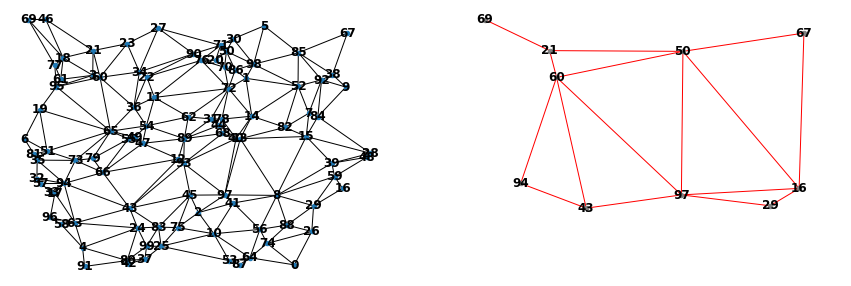

In [73]:
figsize = (15, 5)

node_label = True
node_size = 20

fig, axes = plt.subplots(nrows=1, ncols=2,figsize=figsize)
ax = axes.flatten()

edges = G.edges()
colors = nx.get_edge_attributes(G,'color')
pos = nx.get_node_attributes(G,'pos')
nx.draw(G,pos, with_labels=node_label,node_size=node_size,   font_weight="bold",ax=ax[0])
ax[0].set_axis_off()

# fig, ax = plt.subplots(1, 1, figsize=figsize)

edges = H.edges()
colors = [H[u][v]['color'] for u,v in edges]
pos = nx.get_node_attributes(H,'pos')
nx.draw(H, pos, with_labels=node_label,node_size=node_size, edge_color=colors, font_weight="bold", node_color='grey',ax=ax[1])
ax[1].set_xlim([1.*x for x in ax[0].get_xlim()])
ax[1].set_ylim([1.*y for y in ax[0].get_ylim()])
plt.show()

### Generate sources ( origin-destination, or forcing)

In [74]:
forcing = tl.forcing_generate(G, p = p, weigth = weigth, pos = None, pos_center_of_mass = (0.5,0.5), seed = seedF)
rhs_df = pd.DataFrame(forcing,columns = ['source','sink','weight'])
out_forcing = out_folder + label + '_forcing' + str(seedF) + '.csv'
rhs_df.to_csv(out_forcing,sep=' ',header=True,index=False)

input_path = out_folder
file_edges = label + str(seedG) + '.csv'
df = init.from_nx_graphs2df([G,H],outfile = input_path + file_edges)

edges_file_name = input_path + file_edges

graph, nnode, nedge, nodes,nodes_inter, nodeName2Id, nodeId2Name = init.file2graph(edges_file_name,sep=',')

In [75]:
pflux = np.ones(nedge)
for idx, (u,v,d) in enumerate(list(graph.edges(data=True))):
    pflux[idx] = pflux_map[d['etype']]

### Assign coordinates to nodes and calculate edge lengths

In [76]:
coord_file_name = label + str(seedG) + 'coord.csv'
df_coord = init.from_nx_graph2coord([G,H], nodes, outfile = input_path + coord_file_name, mapping = nodeName2Id,nodes_inter=nodes_inter)
coord_mode = '1'
init.coord_generation(coord_mode, input_path, input_path + coord_file_name, graph, nnode,sep=',')

length_mode = 'eucl'
length_inter0 = 0.1
length0 = init.eucledian_bias(length_mode, graph,length_inter0 = length_inter0, haversine_on=False)

length = init.assign_weights(length0, list(graph.edges(data=True)), alphas)

input_forcing = out_forcing
forcing, comm_list, transit_list = init.forcing_importing_from_file( input_forcing, nodes,nodes_inter,nodeName2Id,sep =' ',header=0,source='source',sink='sink')


coordinates: imported
length: eucledian
forcing: imported from file
Ncom: 99  Ntransit: 120


### Run dynamics

In [34]:
importlib.reload(dyn)

<module 'dynamics' from '/Users/cdebacco/MultiOT/src/dynamics.py'>


dynamics...
cost: 115.33733989217893  - N_real: 0 - Best cost 100000000000000.0
cost: 115.36608965119125  - N_real: 1 - Best cost 115.33733989217893
cost: 115.29603996455864  - N_real: 2 - Best cost 115.33733989217893
cost: 115.33300297391266  - N_real: 3 - Best cost 115.29603996455864
cost: 115.31447056980761  - N_real: 4 - Best cost 115.29603996455864


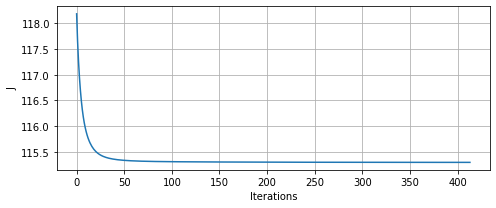

In [35]:
plot_cost = True
opttdens, optpot,  optflux, minCost, minCost_list = dyn.dyn(graph, nodes, pflux, nedge,length, forcing,  tol_var_tdens, comm_list,plot_cost = plot_cost,N_real = N_real, verbose = verbose,seed = seed_dyn) 


In [120]:
importlib.reload(tl)

<module 'tools' from '/Users/cdebacco/tn_sustainability/src/tools.py'>

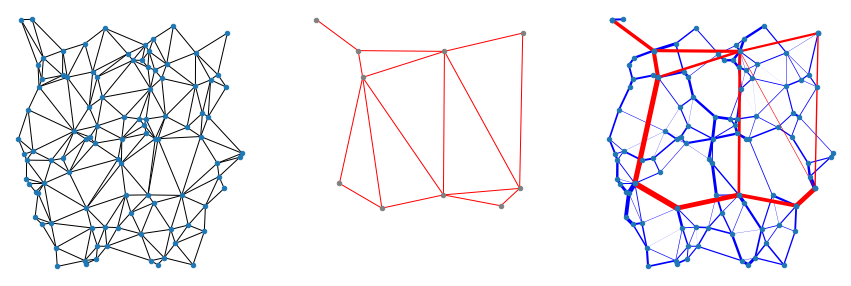

In [36]:
G_plot = tl.plot_results(G,H,graph,opttdens, optpot,optflux, length, flag_trim = False,  ns = 20,
                 wl = False ,w0 = .2, edge_width = 'linear',figsize = (15, 5),tau = None,
                 colors_map = {0:'b',1:'r',2:'g',3:'magenta','inter':'black','inter-super':'black'})

In [124]:
importlib.reload(tl)

<module 'tools' from '/Users/cdebacco/tn_sustainability/src/tools.py'>

### Calculate statistics:
- Gini using optimal fluxes and Current-Flow edge Betweeness Centrality (FBC)

In [55]:
fluxes = { e: optflux[idx] for idx, e in enumerate(list(graph.edges())) }
nx.set_edge_attributes(graph, fluxes,'flux')
ecc0 = nx.edge_current_flow_betweenness_centrality(graph,weight='flux')
edges = list(graph.edges())
ecc = dict(ecc0)
for e in ecc0.keys():
    if e not in edges: ecc[e[1],e[0]] = ecc0[e]

gini_ecc = tl.gini_coefficient(ecc)
gini_flux = tl.gini_coefficient(optflux)

print(f'Gini(Flux):{flt(gini_flux)}, Gini(FBC):{flt(gini_ecc)}')

Gini(Flux):0.55, Gini(FBC):0.51


### Gini and fluxes by layer

In [59]:
flux_per_layer = []
for l in range(2):
    gini_ecc = tl.gini_coefficient([ecc[e] for idx, e in enumerate(list(graph.edges())) if graph.edges[e]['etype'] == l]) 
    gini_flux = tl.gini_coefficient([optflux[idx] for idx, e in enumerate(list(graph.edges())) if graph.edges[e]['etype'] == l])
    
    flux_per_layer.append(np.array([optflux[idx] for idx, e in enumerate(list(graph.edges())) if graph.edges[e]['etype'] == l]))
    
    print(f'Layer: {l+1} -- Gini(Flux): {flt(gini_flux)}, Gini(FBC) {flt(gini_ecc)}')

flux_per_layer = np.array(flux_per_layer,dtype=object)
    
tot_flux0 = flux_per_layer[0].sum()
tot_flux1 = flux_per_layer[1].sum()
tot_flux = tot_flux0 + tot_flux1
tot_flux0 /= tot_flux
tot_flux1 /= tot_flux
E0 , E1 = flux_per_layer[0].shape[0],flux_per_layer[1].shape[0]
print()
print(f'f1: {flt(tot_flux0)}, f2: {flt(tot_flux1)} -- E1: {E0}, E2: {E1}')

Layer: 1 -- Gini(Flux): 0.53, Gini(FBC) 0.49
Layer: 2 -- Gini(Flux): 0.38, Gini(FBC) 0.35

f1: 0.86, f2: 0.14 -- E1: 256, E2: 16


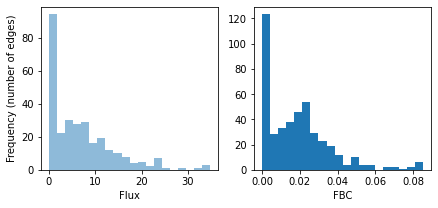

In [67]:
fig, axes = plt.subplots(nrows=1, ncols=2,figsize=(7,3))
ax = axes.flatten()


ax[0].hist(optflux,bins=20,label='flux',density=False,alpha=0.5)
ax[1].hist(ecc.values(),density=False,bins=20)
ax[0].set_xlabel('Flux')
ax[1].set_xlabel('FBC')
ax[0].set_ylabel('Frequency (number of edges)')
plt.show()